In [1]:
import time_evolution as te
import help_functions as hf
import quasi_stationary_investigation as qsi
import cyclic_blockade as cb

import numpy as np
import setup as set
from copy import copy

import cyclic_blockade as cb

import os

def data_dir(t_set, data_format=0):
    format_dir = "format_{}".format(data_format)
    
    # Define the base directory where the data will be saved
    base_dir = "/Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule"
    cwd = os.getcwd()

    # Define the parameters that the data depends on
    params = param_dict()

    angles = t_set.theta_arr()
    for i, key in enumerate(['theta0', 'theta1', 'theta2', 'theta3']):
        params[key] = angles[i]

    overlaps = t_set.overlap_arr()
    for i, key in enumerate(['eps01', 'eps12', 'eps23', 'eps_abs_0', 'eps_abs_1', 'eps_abs_2', 'eps_abs_3']):
        params[key] = overlaps[i]

    # Create a directory with a specific name based on the parameters
    dir_path = os.path.join(base_dir, format_dir)
    os.makedirs(dir_path, exist_ok=True)

    # Save the data to a file with a specific name based on the parameters
    data = [1, 2, 3, 4, 5]
    file_name = "data_{}.npy".format("_".join(["{}-{}".format(k, v) for k, v in params.items()]))
    file_path = os.path.join(dir_path, file_name)
    return file_path

def save_data(data, t_set, data_format=0):
    file_path = data_dir(t_set, data_format)
    np.save(file_path, data)
    print('Data saved in: ', file_path)

def load_data(t_set, data_format=0):
    file_path = data_dir(t_set, data_format)
    try:
        data = np.load(file_path)
        print('Data loaded from: ', file_path)
    except FileNotFoundError:
        print(f'File {filepath} not found')

def param_dict():
    params = {
        "theta0": 0.0,
        "theta1": 0.0,
        "theta2": 0.0,
        "theta3": 0.0,
        "eps01": 0.0,
        "eps12": 0.0,
        "eps23": 0.0,
        "eps_abs_0": 0.0,
        "eps_abs_1": 0.0,
        "eps_abs_2": 0.0,
        "eps_abs_3": 0.0,
        "routine": "1vN"
    }
    return params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
t_set = set.create_transport_setup()
file_path = data_dir(t_set)
print(file_path)

/Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0/data_theta0-0.9424777960769379_theta1-0.0_theta2-0.0_theta3-0.0_eps01-0.001_eps12-0.0015_eps23-0.002_eps_abs_0-0.0005_eps_abs_1-0.001_eps_abs_2-0.0015_eps_abs_3-0.002_routine-1vN.npy


In [5]:
import os
os.environ['MKL_DEBUG_CPU_TYPE'] = '5'

waiting_time = 1e2
n = 1
pre_run = 1e3
qs_desc = False

initialization = 2   
t_set_z = set.create_transport_setup()
timescale = 1e3
waiting_times = np.linspace(1, 4, 5)*timescale
waiting_times = np.power(10, np.linspace(-4.5, 6.2, 1) )
include_Irem = True

charge_random = []
charge_maj = []
angle_arr = []
for idx in range(101):
    angles = np.random.rand(4)*np.pi*2
    print('Run number: ', idx)
    if idx==0:
        t_set_z.model = 1
        angles = np.zeros(4)
    else:
        t_set_z.model = 2
        angle_arr.append(angles)
    
    print(angles)
    
    t_set_z.th0, t_set_z.th1, t_set_z.th2, t_set_z.th3 = angles
    t_set_z.initialize_leads()

    opt_min_z = t_set_z.adjust_to_z_blockade()
    opt_z_successful = opt_min_z.fun < 1e-6
    if not opt_z_successful:
        # If the optimization fails, try again with random phase_angle_guess until it works
        # Print warning if it fails 10 times in a row
        print('Failed to adjust to z-blockade! Trying again with random phase_angle_guess')
        idx = 0
        while not opt_z_successful:
            opt_min_z = t_set_z.adjust_to_z_blockade(phase_angle_guess=np.random.rand()*np.pi*2)
            opt_z_successful = opt_min_z.fun < 1e-6
            idx += 1
            if idx > 10:
                print('Failed to adjust to z-blockade 10 times in a row! Aborting calculation altogether!')
                print(opt_min_z.fun)
                continue

    t_set_z.initialize_box()
    t_set_z.connect_box()

    t_set_x = t_set_z.copy()

    opt_min_x = t_set_x.adjust_to_x_blockade()
    opt_x_successful = opt_min_x.fun < 1e-6
    if not opt_x_successful:
        # If the optimization fails, try again with random phase_angle_guess until it works
        # Print warning if it fails 10 times in a row
        print('Failed to adjust to x-blockade! Trying again with random phase_angle_guess')
        idx = 0
        while not opt_x_successful:
            opt_min_x = t_set_x.adjust_to_x_blockade(phase_angle_guess=np.random.rand()*np.pi*2)
            opt_x_successful = opt_min_x.fun < 1e-6
            idx += 1
            if idx > 10:
                print('Failed to adjust to x-blockade 10 times in a row! Aborting calculation altogether!')
                print(opt_min_x.fun)
                continue

    t_set_x.initialize_leads()
    t_set_x.initialize_box()
    t_set_x.connect_box()

    sys_z = t_set_z.build_qmeq_sys()
    sys_x = t_set_x.build_qmeq_sys()

    sys_z.solve(qdq=False, rotateq=False)
    sys_x.solve(qdq=False, rotateq=False)
    print(sys_z.current, sys_x.current )

    rho0, sys_z, sys_x, current_fct_z, current_fct_x, time_evo_rho_z, time_evo_rho_x = cb.initialize_cycle_fcts(t_set_z, t_set_x, qs_desc, initialization, lead=0)
    res = np.array([cb.charge_transmission_cycle(current_fct_z, current_fct_x, time_evo_rho_z, time_evo_rho_x, rho0, n, waiting_time, sys_z, pre_run=pre_run, include_Irem=include_Irem) for waiting_time in waiting_times ] )

    save_data(np.transpose([waiting_times, res]), t_set_z, data_format=0)
    
    if idx == 0:
        charge_maj.append(res)
    else:
        charge_random.append(res)

charge_maj = np.array(charge_maj)
charge_random = np.array(charge_random)

Run number:  0
[0. 0. 0. 0.]
[ 1.77439592e-07 -1.77439592e-07] [ 7.11278649e-07 -7.11278650e-07]
Data saved in:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0/data_theta0-0.0_theta1-0.0_theta2-0.0_theta3-0.0_eps01-0.001_eps12-0.0015_eps23-0.002_eps_abs_0-0.0005_eps_abs_1-0.001_eps_abs_2-0.0015_eps_abs_3-0.002_routine-1vN.npy
Run number:  1
[3.17769581 4.41989697 4.52984004 1.08038754]
[ 1.25401972e-08 -1.25401971e-08] [ 1.14391144e-08 -1.14391138e-08]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNIN

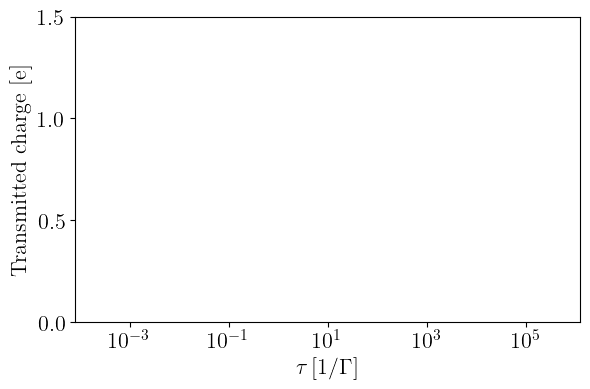

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

fig, ax = plt.subplots(1,1, figsize=(6,4))
timescale = (t_set_z.eps_abs_0)**(-1)
timescale = 1

data = charge_random
#data = charge
ax.plot(waiting_times/timescale, np.transpose(data), c='gray' )
ax.plot(waiting_times, np.transpose(charge_maj), c='r')

fs = 16

#ax.legend([r'$\theta_2 = {:.2f} \, \pi$'.format(angle/np.pi) for angle in angles])
ax.set_xlabel(r'$\tau \, [1/\Gamma]$', size=fs)
ax.set_ylabel('Transmitted charge [e]', size=fs)
ax.set_ylim(bottom=0, top=1.5)
ax.set_xlim(left=5e-4, right=5e5)

# Set number of ticks for y-axis manually
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_xlim([0.8e-4, 1.2e6])
ax.set_xticks([1e-4, 1e-2, 1e0, 1e2, 1e4])

ax.set_xscale('log')
ax.tick_params(labelsize=fs)
# ax.grid()
plt.tight_layout()
plt.show()

#Save created plot as regular picture
#plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_charge-blocktime_f1=1-f2=1-f3=1_th0=0-th1=0-th2=sweep_1vN.pdf', format='pdf')
#Save as zoom
#plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_charge-blocktime_f1=1-f2=1-f3=1_th0=0-th1=0-th2=sweep_1vN_zoom.pdf', format='pdf')
#Save as random sampling
plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_charge-blocktime_f1=1-f2=1-f3=1_thetas-randomized_1vN.pdf', format='pdf')
#Save as th3-sweep
#plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_charge-blocktime_f1=1-f2=1-f3=1_th3=sweep_1vN.pdf', format='pdf')

In [9]:
print(file_path)

/Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0/data_theta0-0.9424777960769379_theta1-0.0_theta2-0.0_theta3-0.0_eps01-0.001_eps12-0.0015_eps23-0.002_eps_abs_0-0.0005_eps_abs_1-0.001_eps_abs_2-0.0015_eps_abs_3-0.002_routine-1vN.npy


In [15]:
waiting_time = 1e2
n = 1
pre_run = 1e3
qs_desc = False

initialization = 2              ### Initialization routines 0: stationary state of system;
                                ### 1: 1 at first occupation, 0 otherwise; 2: maximally mixed state

t_set_z = set.create_transport_setup()

timescale = (t_set_z.eps_abs_0)**(-1)
timescale = 1e3

waiting_times = np.linspace(1, 4, 4)*timescale
waiting_times = np.power(10, np.linspace(-1, 3, 10) )

include_Irem = True

angle_arr  = [[0, 0, 0, 0.99*np.pi/2]]
angle_arr  = np.array([ [0, 0, 0, fac*np.pi] for fac in np.linspace(0, 1, 10) ])
charge  = []
for angles in angle_arr:
    print(angles/np.pi)
    t_set_z.th0, t_set_z.th1, t_set_z.th2, t_set_z.th3 = angles
    t_set_z.initialize_leads()
    t_set_z.adjust_to_z_blockade()
    t_set_z.initialize_box()
    t_set_z.connect_box()

    t_set_x = t_set_z.copy()

    t_set_x.adjust_to_x_blockade()
    t_set_x.initialize_leads()
    t_set_x.initialize_box()
    t_set_x.connect_box()

    sys_z = t_set_z.build_qmeq_sys()
    sys_x = t_set_x.build_qmeq_sys()

    sys_z.solve(qdq=False, rotateq=False)
    sys_x.solve(qdq=False, rotateq=False)
    print(sys_z.current, sys_x.current )


    qsi.analytical_prediction(t_set_z.th2 )

    rho0, sys_z, sys_x, current_fct_z, current_fct_x, time_evo_rho_z, time_evo_rho_x = cb.initialize_cycle_fcts(t_set_z, t_set_x, qs_desc, initialization, lead=0)
    
    charge.append(np.array([cb.charge_transmission_cycle(current_fct_z, current_fct_x, time_evo_rho_z, time_evo_rho_x, rho0, n, waiting_time, sys_z, pre_run=pre_run, include_Irem=include_Irem) for waiting_time in waiting_times ] ) )

charge = np.array(charge)

[0. 0. 0. 0.]
[ 1.77674057e-08 -1.77674054e-08] [ 1.89822701e-08 -1.89822697e-08]
ePlus squared:  1.0
eMinus squared:  1.0
Analytically predicted charge:  0.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enab

KeyboardInterrupt: 